In [83]:
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio
import os
from rasterio.transform import from_origin
from rasterio import features as rfeatures
import xarray as xr
from datetime import datetime

from matplotlib import pyplot as plt
from cartopy import crs as ccrs

In [45]:
nuts_2021 = gpd.read_file("../NUTS2021/NUTS_RG_20M_2021_4326.shp")
nuts_2024 = gpd.read_file("../NUTS2024/NUTS_RG_20M_2024_4326.shp")

In [82]:
nuts_iso3_name = {
    'AL': ('ALB', 'Albania'),
    'AT': ('AUT', 'Austria'),
    'BA': ('BIH', 'Bosnia and Herzegovina'),
    'BE': ('BEL', 'Belgium'),
    'BG': ('BGR', 'Bulgaria'),
    'CH': ('CHE', 'Switzerland'),
    'CY': ('CYP', 'Cyprus'),
    'CZ': ('CZE', 'Czechia'),
    'DE': ('DEU', 'Germany'),
    'DK': ('DNK', 'Denmark'),
    'EE': ('EST', 'Estonia'),
    'EL': ('GRC', 'Greece'),            # NUTS uses EL (not GR)
    'ES': ('ESP', 'Spain'),
    'FI': ('FIN', 'Finland'),
    'FR': ('FRA', 'France'),
    'HR': ('HRV', 'Croatia'),
    'HU': ('HUN', 'Hungary'),
    'IE': ('IRL', 'Ireland'),
    'IS': ('ISL', 'Iceland'),
    'IT': ('ITA', 'Italy'),
    'LI': ('LIE', 'Liechtenstein'),
    'LT': ('LTU', 'Lithuania'),
    'LU': ('LUX', 'Luxembourg'),
    'LV': ('LVA', 'Latvia'),
    'ME': ('MNE', 'Montenegro'),
    'MK': ('MKD', 'North Macedonia'),
    'MT': ('MLT', 'Malta'),
    'NL': ('NLD', 'Netherlands'),
    'NO': ('NOR', 'Norway'),
    'PL': ('POL', 'Poland'),
    'PT': ('PRT', 'Portugal'),
    'RO': ('ROU', 'Romania'),
    'RS': ('SRB', 'Serbia'),
    'SE': ('SWE', 'Sweden'),
    'SI': ('SVN', 'Slovenia'),
    'SK': ('SVK', 'Slovakia'),
    'TR': ('TUR', 'Türkiye'),
    'UA': ('UKR', 'Ukraine'),
    'UK': ('GBR', 'United Kingdom'),    # NUTS uses UK (not GB)
    'XK': ('XKO', 'Kosovo')             # unofficial ISO3 commonly used in EU datasets
}


In [46]:
nuts_2021.loc[nuts_2021['LEVL_CODE'] == 0, 'ISO3'] = nuts_2021.loc[nuts_2021['LEVL_CODE'] == 0, 'CNTR_CODE'].map(lambda x: nuts_iso3_name.get(x, (None, None))[0])
nuts_2021.loc[nuts_2021['LEVL_CODE'] == 0, 'NAME_ENG'] = nuts_2021.loc[nuts_2021['LEVL_CODE'] == 0, 'CNTR_CODE'].map(lambda x: nuts_iso3_name.get(x, (None, None))[1])

In [47]:
nuts_2021.loc[nuts_2021['LEVL_CODE'] == 0]

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry,ISO3,NAME_ENG
0,FR,0,FR,France,France,0.0,0,0,"MULTIPOLYGON (((55.21471 -21.03851, 55.27392 -...",FRA,France
1,HR,0,HR,Hrvatska,Hrvatska,0.0,0,0,"MULTIPOLYGON (((16.59681 46.47590, 16.85476 46...",HRV,Croatia
2,HU,0,HU,Magyarország,Magyarország,0.0,0,0,"POLYGON ((21.42465 48.57472, 21.60691 48.49458...",HUN,Hungary
3,AL,0,AL,Shqipëria,Shqipëria,0.0,0,0,"POLYGON ((19.73492 42.63238, 19.83100 42.46645...",ALB,Albania
4,AT,0,AT,Österreich,Österreich,0.0,0,0,"POLYGON ((15.75363 48.85218, 16.29009 48.73395...",AUT,Austria
5,BE,0,BE,Belgique/België,Belgique/België,0.0,0,0,"POLYGON ((4.75993 51.50246, 4.86400 51.43362, ...",BEL,Belgium
6,BG,0,BG,Bulgaria,България,0.0,0,0,"POLYGON ((22.85777 43.87577, 22.99717 43.80787...",BGR,Bulgaria
7,CH,0,CH,Schweiz/Suisse/Svizzera,Schweiz/Suisse/Svizzera,0.0,0,0,"POLYGON ((8.67046 47.68486, 8.79571 47.67560, ...",CHE,Switzerland
8,CY,0,CY,Kýpros,Κύπρος,0.0,0,0,"POLYGON ((32.27382 35.06649, 32.28884 35.10503...",CYP,Cyprus
9,CZ,0,CZ,Česko,Česko,0.0,0,0,"POLYGON ((14.61880 50.85780, 14.76738 50.81985...",CZE,Czechia


In [48]:
nuts_2024.loc[nuts_2024['LEVL_CODE'] == 0, 'ISO3'] = nuts_2024.loc[nuts_2024['LEVL_CODE'] == 0, 'CNTR_CODE'].map(lambda x: nuts_iso3_name.get(x, (None, None))[0])
nuts_2024.loc[nuts_2024['LEVL_CODE'] == 0, 'NAME_ENG'] = nuts_2024.loc[nuts_2024['LEVL_CODE'] == 0, 'CNTR_CODE'].map(lambda x: nuts_iso3_name.get(x, (None, None))[1])

In [49]:
nuts_2024.loc[nuts_2024['LEVL_CODE'] == 0]

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry,ISO3,NAME_ENG
79,SI,0,SI,Slovenija,Slovenija,NaN,NaN,NaN,"POLYGON ((16.11385 46.86907, 16.13460 46.85608...",SVN,Slovenia
80,SK,0,SK,Slovensko,Slovensko,NaN,NaN,NaN,"POLYGON ((19.65557 49.41322, 19.78063 49.38921...",SVK,Slovakia
111,TR,0,TR,Türkiye,Türkiye,NaN,NaN,NaN,"MULTIPOLYGON (((35.14203 42.02822, 35.12468 41...",TUR,Türkiye
137,UA,0,UA,Ukraina,Україна,NaN,NaN,NaN,"MULTIPOLYGON (((33.42917 52.34571, 33.62656 52...",UKR,Ukraine
138,XK,0,XK,Kosovo*,Kosovo*,NaN,NaN,NaN,"POLYGON ((21.43512 42.87228, 21.43757 42.78291...",XKO,Kosovo
163,AL,0,AL,Shqipëria,Shqipëria,NaN,NaN,NaN,"POLYGON ((19.70485 42.63906, 19.83093 42.46638...",ALB,Albania
179,AT,0,AT,Österreich,Österreich,NaN,NaN,NaN,"POLYGON ((15.75363 48.85218, 16.29276 48.73385...",AUT,Austria
180,BA,0,BA,Bosna I Hercegovina,Bosna I Hercegovina,0.0,NaN,NaN,"MULTIPOLYGON (((16.94510 45.24440, 17.14119 45...",BIH,Bosnia and Herzegovina
181,BE,0,BE,Belgique/België,Belgique/België,NaN,NaN,NaN,"POLYGON ((4.75993 51.50246, 4.87977 51.42775, ...",BEL,Belgium
182,BG,0,BG,Bulgaria,България,NaN,NaN,NaN,"POLYGON ((22.85904 43.89820, 22.99717 43.80787...",BGR,Bulgaria


In [25]:
# Get the difference between the two versions
nuts_2021_ids = set(nuts_2021.loc[nuts_2021['LEVL_CODE'] == 0]['NUTS_ID'])
nuts_2024_ids = set(nuts_2024.loc[nuts_2024['LEVL_CODE'] == 0]['NUTS_ID'])
added_nuts = nuts_2024_ids - nuts_2021_ids
removed_nuts = nuts_2021_ids - nuts_2024_ids

In [26]:
added_nuts

{'BA', 'UA', 'XK'}

In [27]:
removed_nuts

{'UK'}

/tmp/ipykernel_1304661/2275441997.py:9: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


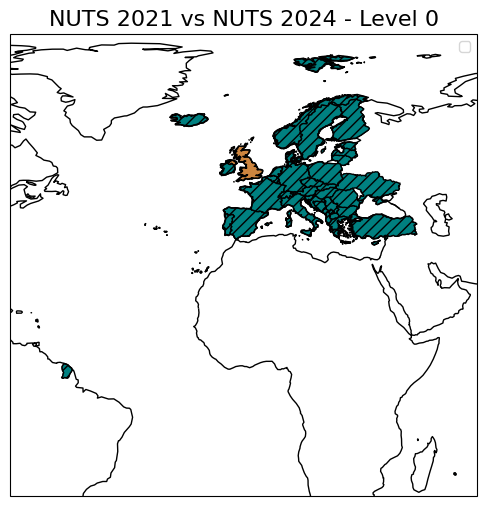

In [32]:
f, ax = plt.subplots(1,1, figsize=(12,6), subplot_kw={'projection': ccrs.PlateCarree()})

nuts_2021.loc[nuts_2021['LEVL_CODE'] == 0].plot(ax=ax, edgecolor='black', facecolor='peru', label='NUTS 2021')

nuts_2024.loc[nuts_2024['LEVL_CODE'] == 0].plot(ax=ax, edgecolor='black', facecolor='teal', label='NUTS 2024', hatch='///')

ax.set_title('NUTS 2021 vs NUTS 2024 - Level 0', fontsize=16)
ax.coastlines()
ax.legend()

plt.show()

In [51]:
def country_masks_to_xr(
    shp_path: str,
    *,
    id_dict: dict | None = None,
    id_field: str = "NUTS_ID",
    name_field: str = "NUTS_NAME",
    level_field: str = "LEVL_CODE",
    level_value: int | None = 0,
    extent: tuple | None = None,        # (min_x, max_x, min_y, max_y) in EPSG:4326
    target_res: float | tuple = 0.25,   # scalar -> square; tuple(lat_res, lon_res)
    super_sample: int | tuple = 1,       # scalar or tuple(lat_factor, lon_factor)
    all_touched: bool = False,
    out_nc: str | None = None
) -> xr.Dataset:
    """
    Build per-country masks (or fractions if super_sample>1) on a lat/lon grid.

    - target_res: float or (lat_res, lon_res) in degrees.
    - super_sample: int or (lat_factor, lon_factor). If >1, burn at finer grid and
      coarsen with mean to get fractions in [0,1]. If ==1, returns uint8 masks.
    """
    # ---- Load & CRS
    gdf = gpd.read_file(shp_path)
    if gdf.crs is None or gdf.crs.to_string().upper() != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")

    if level_field is not None and level_value is not None:
        gdf = gdf.loc[gdf[level_field] == level_value].copy()

    if id_dict is not None:
        gdf['ISO3'] = gdf[id_field].map(lambda x: id_dict.get(x, (None, None))[0])
        gdf['NAME_ENG'] = gdf[id_field].map(lambda x: id_dict.get(x, (None, None))[1])

    # ---- Extent
    if extent is None:
        minx, miny, maxx, maxy = gdf.total_bounds
    else:
        # user provided (min_x, max_x, min_y, max_y)
        minx, miny, maxx, maxy = extent

    # ---- Normalize resolution & supersampling
    if isinstance(target_res, (int, float)):
        dlat_t, dlon_t = float(target_res), float(target_res)
    else:
        dlat_t, dlon_t = map(float, target_res)

    if isinstance(super_sample, int):
        s_lat = s_lon = int(super_sample)
    else:
        s_lat, s_lon = map(int, super_sample)

    # base resolution used for rasterization
    dlat_b = dlat_t / max(s_lat, 1)
    dlon_b = dlon_t / max(s_lon, 1)

    # ---- Align bounds to base resolution
    def _down(v, res): return np.floor(v / res) * res
    def _up(v, res):   return np.ceil(v / res)  * res

    west  = _down(minx, dlon_b)
    east  = _up(maxx,  dlon_b)
    south = _down(miny, dlat_b)
    north = _up(maxy,  dlat_b)

    width  = int(round((east  - west)  / dlon_b))
    height = int(round((north - south) / dlat_b))

    transform = from_origin(west, north, dlon_b, dlat_b)

    # ---- Value column & IDs
    if "value" not in gdf.columns:
        gdf["value"] = 1
    if 'ISO3' in gdf.columns:
        id_field = 'ISO3'
        name_field = 'NAME_ENG'
    unique_ids = np.unique(gdf[id_field].values)
    unique_names = np.unique(gdf[name_field].values)

    # ---- Dtype: binary masks vs fractions
    want_fraction = (s_lat > 1 or s_lon > 1)
    dtype = "float32" if want_fraction else "uint8"

    base_masks = np.zeros((unique_ids.shape[0], height, width), dtype=dtype)

    # ---- Rasterize per country at base resolution
    for j, uid in enumerate(unique_ids):
        sub = gdf.loc[gdf[id_field] == uid]
        shapes = ((geom, int(val)) for geom, val in zip(sub.geometry, sub["value"]))
        arr = rfeatures.rasterize(
            shapes=shapes,
            out_shape=(height, width),
            transform=transform,
            fill=0,
            all_touched=all_touched,
            dtype="uint8",          # burn as uint8 (0/1) then cast if needed
        )
        arr = np.flipud(arr)        # flip so lat increases bottom→top
        base_masks[j] = arr.astype(dtype, copy=False)

    # ---- Base coords (centers)
    lat_base = np.linspace(south + dlat_b/2, north - dlat_b/2, height)
    lon_base = np.linspace(west  + dlon_b/2, east  - dlon_b/2, width)

    ds_base = xr.Dataset(
        {"country_fraction": (["countries", "lat", "lon"], base_masks)},
        coords={"countries": unique_ids, "lat": lat_base, "lon": lon_base},
        attrs={
            "Source": "https://ec.europa.eu/eurostat/web/gisco/geodata/statistical-units/territorial-units-statistics",
            "crs": "EPSG:4326",
            "processed_by": "Carlos Gómez-Ortiz",
            "base_res_lat_deg": float(dlat_b),
            "base_res_lon_deg": float(dlon_b),
            "target_res_lat_deg": float(dlat_t),
            "target_res_lon_deg": float(dlon_t),
            "created_utc": datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S"),
            "all_touched_flag": int(bool(all_touched)),  # NetCDF-safe (0/1)
            "note": "If super_sample>1 in either axis, country_fraction is an area fraction via supersampling; else it is a binary mask.",
        },
    )
    ds_base["country_ID"] = ("countries", unique_ids)
    ds_base["country_name"] = ("countries", unique_names)

    # ---- Aggregate to target grid (mean of 0/1 -> fraction)
    if want_fraction:
        ds = ds_base.coarsen(
            lat=s_lat, lon=s_lon, boundary="trim"
        ).mean()
    else:
        ds = ds_base

    # ---- Optional NetCDF
    if out_nc:
        ds.to_netcdf(out_nc)

    return ds


In [79]:
res = 1
path_in = os.path.join("..", "NUTS2024", "NUTS_RG_20M_2024_4326.shp")
folder_name = os.path.basename(os.path.normpath(os.path.dirname(path_in)))

if isinstance(res, int) or isinstance(res, float):
    path_out = os.path.join(
        'output',
        folder_name,
        os.path.basename(path_in).replace(".shp", f"_masks_{res}deg.nc")
    )

    ds = country_masks_to_xr(
    path_in,
    id_dict=nuts_iso3_name,
    level_value=0,
    target_res=res,    # (lat_res, lon_res)
    super_sample=(5,5),
    extent=(-15, 33, 35, 73), # (min_x, max_x, min_y, max_y)
    out_nc=path_out,
    )

if isinstance(res, tuple):
    path_out = os.path.join(
        'output',
        folder_name, 
        os.path.basename(path_in).replace(".shp", f"_masks_{res[0]}x{res[1]}deg.nc")
        )

    ds = country_masks_to_xr(
        path_in,
        id_dict=nuts_iso3_name,
        level_value=0,
        target_res=res,    # (lat_res, lon_res)
        super_sample=5,
        extent=(-15, 33, 35, 73), # (min_x, max_x, min_y, max_y)
        out_nc=path_out,
    )

In [67]:
res = 1
path_in = os.path.join("..", "NUTS2021", "NUTS_RG_20M_2021_4326.shp")

# Extract folder name cleanly (NUTS2021)
folder_name = os.path.basename(os.path.normpath(os.path.dirname(path_in)))

if isinstance(res, int):
    path_out = os.path.join(
        folder_name,
        os.path.basename(path_in).replace(".shp", f"_masks_{res}deg.nc")
    )

elif isinstance(res, tuple):
    path_out = os.path.join(
        os.path.dirname(path_in),
        f"{folder_name}_masks_{res[0]}x{res[1]}deg.nc"
    )

print(path_out)

NUTS2021/NUTS_RG_20M_2021_4326_masks_1deg.nc


In [74]:
ds

<xarray.Dataset>
Dimensions:           (countries: 37, lat: 40, lon: 25)
Coordinates:
  * countries         (countries) object 'ALB' 'AUT' 'BEL' ... 'SVN' 'SWE' 'TUR'
  * lat               (lat) float64 33.5 34.5 35.5 36.5 ... 69.5 70.5 71.5 72.5
  * lon               (lon) float64 -14.2 -12.2 -10.2 -8.2 ... 29.8 31.8 33.8
Data variables:
    country_fraction  (countries, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    country_ID        (countries) object 'ALB' 'AUT' 'BEL' ... 'SVN' 'SWE' 'TUR'
    country_name      (countries) object 'Albania' ... 'United Kingdom'
Attributes:
    Source:              https://ec.europa.eu/eurostat/web/gisco/geodata/stat...
    crs:                 EPSG:4326
    processed_by:        Carlos Gómez-Ortiz
    base_res_lat_deg:    0.2
    base_res_lon_deg:    0.4
    target_res_lat_deg:  1.0
    target_res_lon_deg:  2.0
    created_utc:         2025-10-23 10:59:01
    all_touched_flag:    0
    note:                If super_sample>1 in either axis, country_fraction i...

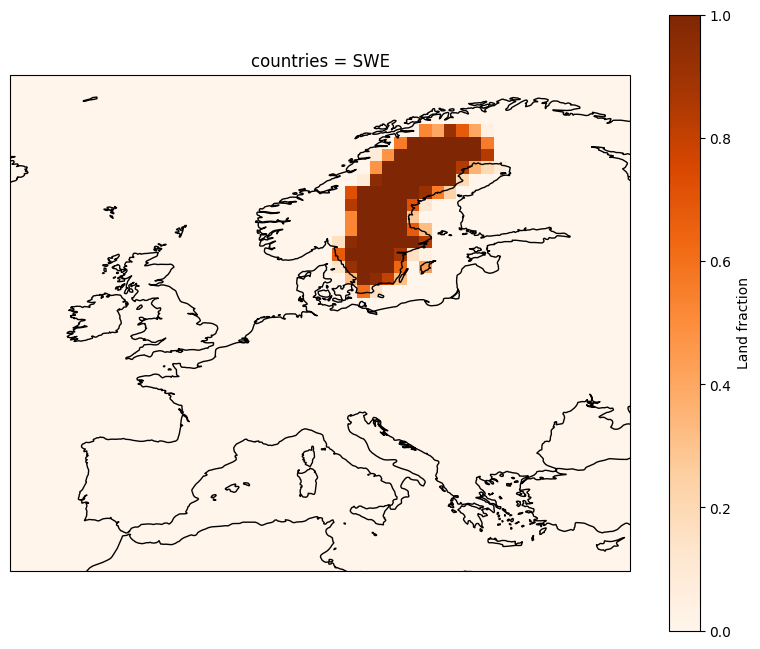

In [81]:
f, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10,8))

ds.country_fraction.sel(countries="SWE").plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="Oranges",
    cbar_kwargs={"label": "Land fraction"},
)

ax.coastlines()